In [1]:
import logging
from ananke.models.collection import Collection
from ananke.configurations.collection import HDF5StorageConfiguration
logging.getLogger().setLevel(logging.INFO)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import time

In [ ]:
# Function to count how many entries are in the interval
def count_in_interval(lst, lower_bound, upper_bound):
    return sum(lower_bound <= x <= upper_bound for x in lst)

def custom_agg(x):
    if isinstance(x.iloc[0], list):
        return sum(x, [])
    else:
        return x.sum()

In [2]:
path="data/HexRealTracks.h5"

In [ ]:
config=HDF5StorageConfiguration(data_path=path,read_only=False)
collection=Collection(config)
collection.open()
hits=collection.storage.get_hits()
sources=collection.storage.get_sources()
collection.close()
records=hits.df['record_id'].drop_duplicates()

In [ ]:
hits.df

In [ ]:
def return_hits_and_intervals(path:str):
    config=HDF5StorageConfiguration(data_path=path,read_only=False)
    collection=Collection(config)
    collection.open()
    hits=collection.storage.get_hits()
    collection.close()
    upperlimit=hits.get_statistics().max
    lowerlimit=hits.get_statistics().min
    times=np.arange(lowerlimit,upperlimit+100,100)
    return hits,times

In [ ]:
def trigger_dataset(path:str,merge_records:bool=True):
    hits,times=return_hits(path)
    if merge_records:
        hits=hits.df.assign(record_id=1)
        record=hits['record_id'].drop_duplicates()
    NumberOfModsTriggeredPerRec=[]
    HitsPerIntervalPerRec=[]
    HitTiming=[]
    
    return 0

In [ ]:
upperlimit=hits.get_statistics().max
lowerlimit=hits.get_statistics().min
times=np.arange(lowerlimit,upperlimit+100,100)


total_time=time.time()
NumberOfModsTriggeredPerRec=[]
HitsPerIntervalPerRec=[]
HitTiming=[]
NumberOfModsPerRecUT=[]
HitsPerIntervalPerRecUT=[]
HitTimingUT=[]
for record in records:
    record_time=time.time()
    print('record: ',record,' started')
    time_per_record=time.time()
    hit=hits.get_by_record_ids(record)

    hit=hit.df.groupby(["string_id",'module_id','pmt_id'])['time'].apply(list).reset_index()
    #display(hit.head(1))
    #display(hit.shape)
    for i,j in zip(times,times[1:]):
        hit['hit_in_interval_'+str(i)+'-'+str(j)] = hit['time'].apply(lambda x: count_in_interval(x, i, j))
    column_name=[]
    #display(hit.head(1))
    #display(hit.shape)
    for i,_ in hit.items():
        if i[0]=="h":
            column_name.append(i)

    TriggerDataList=[]
    triggerfreedata=[]
    #display(hit.head(1))
    for name in column_name:
        trigger_data=hit[['string_id','module_id','pmt_id','time',name]]
        trigger_data=trigger_data[trigger_data[name]!=0]
        trigger_data = trigger_data.groupby(['string_id', 'module_id']).agg({'time': lambda x: sum(x, []),name: list}).reset_index()
        trigger_data['pmts_hit_in_interval_'+name[18:]]=trigger_data[name].apply(len)
        untriggered_data=trigger_data.copy()
        trigger_data=trigger_data[trigger_data['pmts_hit_in_interval_'+name[18:]]>7]
        untriggered_data[name]=untriggered_data[name].apply(sum)
        trigger_data[name]=trigger_data[name].apply(sum)
        trigger_data.rename(columns={name: 'ModuleHitCount'+name[18:]}, inplace=True)
        untriggered_data.rename(columns={name: 'ModuleHitCount'+name[18:]}, inplace=True)
        TriggerDataList.append(trigger_data)
        triggerfreedata.append(untriggered_data)

    StackedTriggerData=pd.concat(TriggerDataList, ignore_index=True, axis=0)
    StackedTriggerFreeData=pd.concat(triggerfreedata, ignore_index=True, axis=0)
    StackedTriggerData.fillna(0,inplace=True)
    StackedTriggerFreeData.fillna(0,inplace=True)
    if StackedTriggerData.shape[0]>1:
        StackedTriggerData=StackedTriggerData.groupby(['string_id','module_id']).agg(custom_agg).reset_index()
        StackedTriggerFreeData=StackedTriggerFreeData.groupby(['string_id','module_id']).agg(custom_agg).reset_index()
    
    hits_per_interval=[]
    number_of_modules_triggered=[]
    number_of_modules_hit=[]
    untriggered_hits_per_interval=[]
    for i,_ in StackedTriggerData.items():
        if i[0]=="M":
            number_of_modules_triggered.append(StackedTriggerData[StackedTriggerData[i]>0].shape[0])
            number_of_modules_hit.append(StackedTriggerFreeData[StackedTriggerFreeData[i]>0].shape[0])
            hits_per_interval.append(sum(StackedTriggerData[i]))
            untriggered_hits_per_interval.append(sum(StackedTriggerFreeData[i]))
    NumberOfModsTriggeredPerRec.append(number_of_modules_triggered)
    HitsPerIntervalPerRec.append(hits_per_interval)
    HitTiming.append(StackedTriggerData['time'])
    NumberOfModsPerRecUT.append(number_of_modules_hit)
    HitsPerIntervalPerRecUT.append(untriggered_hits_per_interval)
    HitTimingUT.append(StackedTriggerFreeData['time'])
    print(time.time()-record_time)
print(time.time()-total_time)

In [ ]:
upperlimit=hits.get_statistics().max
lowerlimit=hits.get_statistics().min
times=np.arange(lowerlimit,upperlimit+100,100)


total_time=time.time()
NumberOfModsTriggeredPerRec=[]
HitsPerIntervalPerRec=[]
HitTiming=[]
NumberOfModsPerRecUT=[]
HitsPerIntervalPerRecUT=[]
HitTimingUT=[]
for record in records:
    record_time=time.time()
    print('record: ',record,' started')
    time_per_record=time.time()
    hit=hits.get_by_record_ids(record)

    hit=hit.df.groupby(["string_id",'module_id','pmt_id'])['time'].apply(list).reset_index()

    for i,j in zip(times,times[1:]):
        hit['hit_in_interval_'+str(i)+'-'+str(j)] = hit['time'].apply(lambda x: count_in_interval(x, i, j))
    column_name=[]
    for i,_ in hit.items():
        if i[0]=="h":
            column_name.append(i)

    TriggerDataList=[]
    triggerfreedata=[]
    #display(hit.head(3))
    for name in column_name:
        trigger_data=hit[['string_id','module_id','pmt_id','time',name]]
        trigger_data=trigger_data[trigger_data[name]!=0]
        trigger_data = trigger_data.groupby(['string_id', 'module_id']).agg({'time': lambda x: sum(x, []),name: list}).reset_index()
        trigger_data['pmts_hit_in_interval_'+name[18:]]=trigger_data[name].apply(len)
        untriggered_data=trigger_data.copy()
        trigger_data=trigger_data[trigger_data['pmts_hit_in_interval_'+name[18:]]>7]
        untriggered_data[name]=untriggered_data[name].apply(sum)
        trigger_data[name]=trigger_data[name].apply(sum)
        trigger_data.rename(columns={name: 'ModuleHitCount'+name[18:]}, inplace=True)
        untriggered_data.rename(columns={name: 'ModuleHitCount'+name[18:]}, inplace=True)
        TriggerDataList.append(trigger_data)
        triggerfreedata.append(untriggered_data)

    StackedTriggerData=pd.concat(TriggerDataList, ignore_index=True, axis=0)
    StackedTriggerFreeData=pd.concat(triggerfreedata, ignore_index=True, axis=0)
    StackedTriggerData.fillna(0,inplace=True)
    StackedTriggerFreeData.fillna(0,inplace=True)
    if StackedTriggerData.shape[0]>1:
        StackedTriggerData=StackedTriggerData.groupby(['string_id','module_id']).agg(custom_agg).reset_index()
        StackedTriggerFreeData=StackedTriggerFreeData.groupby(['string_id','module_id']).agg(custom_agg).reset_index()
    
    hits_per_interval=[]
    number_of_modules_triggered=[]
    number_of_modules_hit=[]
    untriggered_hits_per_interval=[]
    for i,_ in StackedTriggerData.items():
        if i[0]=="M":
            number_of_modules_triggered.append(StackedTriggerData[StackedTriggerData[i]>0].shape[0])
            number_of_modules_hit.append(StackedTriggerFreeData[StackedTriggerFreeData[i]>0].shape[0])
            hits_per_interval.append(sum(StackedTriggerData[i]))
            untriggered_hits_per_interval.append(sum(StackedTriggerFreeData[i]))
    NumberOfModsTriggeredPerRec.append(number_of_modules_triggered)
    HitsPerIntervalPerRec.append(hits_per_interval)
    HitTiming.append(StackedTriggerData['time'])
    NumberOfModsPerRecUT.append(number_of_modules_hit)
    HitsPerIntervalPerRecUT.append(untriggered_hits_per_interval)
    HitTimingUT.append(StackedTriggerFreeData['time'])
    print(time.time()-record_time)
print(time.time()-total_time)

In [ ]:
from TriggerVectorize import TriggerDatasetProcessor as TDP

In [6]:
import trigger_copy
from trigger_parallel import TriggerDatasetProcessor as TDP
reload(trigger_copy)
from trigger_copy import TriggerDatasetProcessor as TDP

In [5]:
from importlib import reload


In [ ]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [7]:
process=TDP(path)
process.trigger_intervals=100
process.trigger_threshhold=7
a,b,c=process.run()
#size.append(process.times.shape[0])

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [13]:
records=process.records
intervals=process.intervals

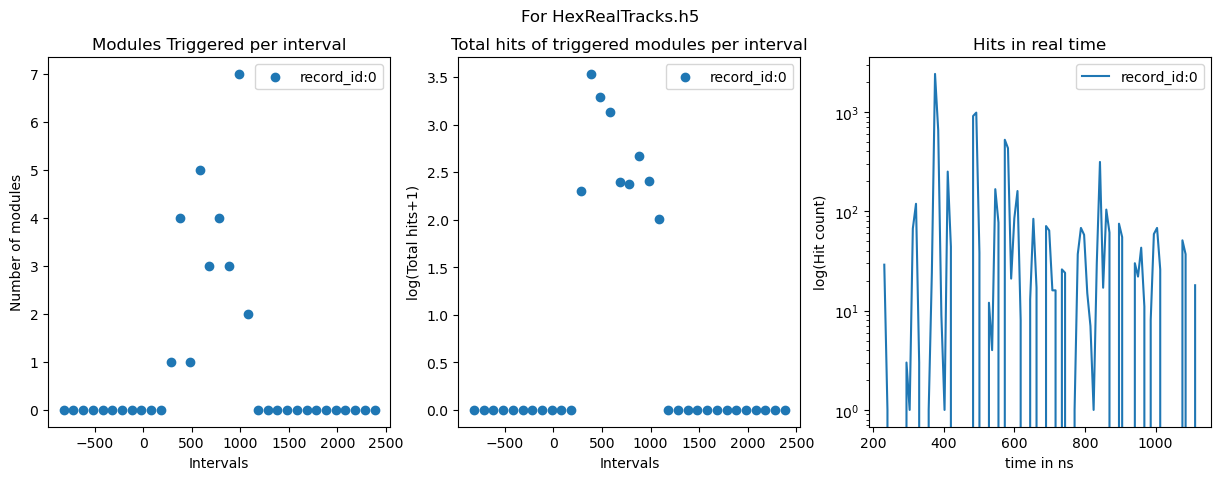

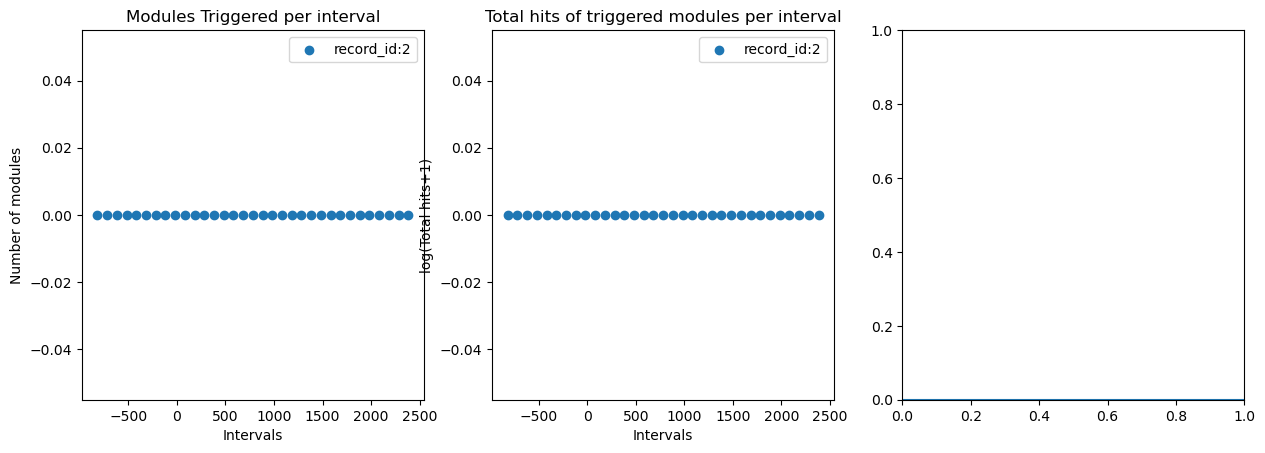

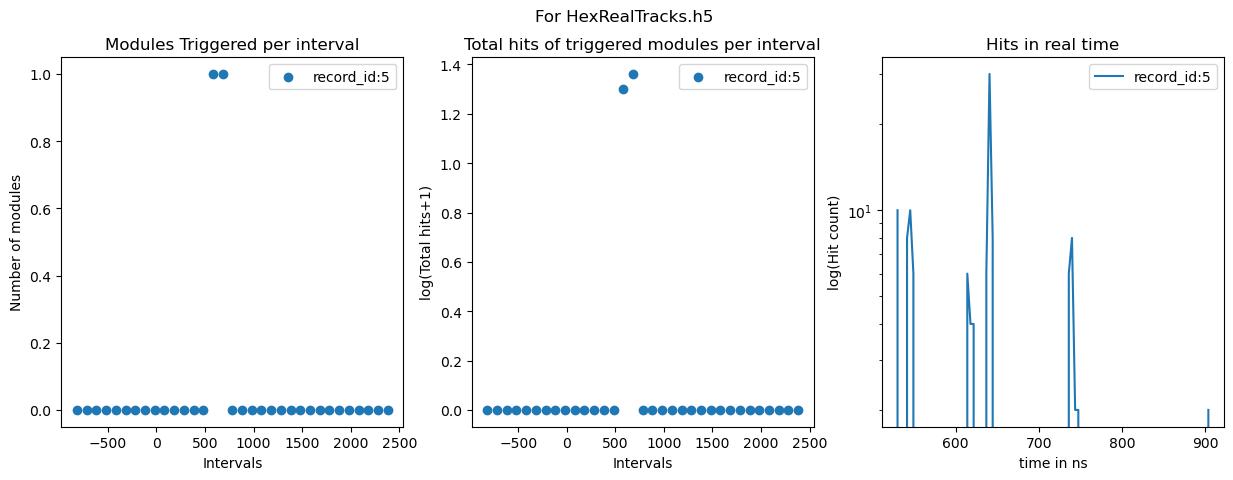

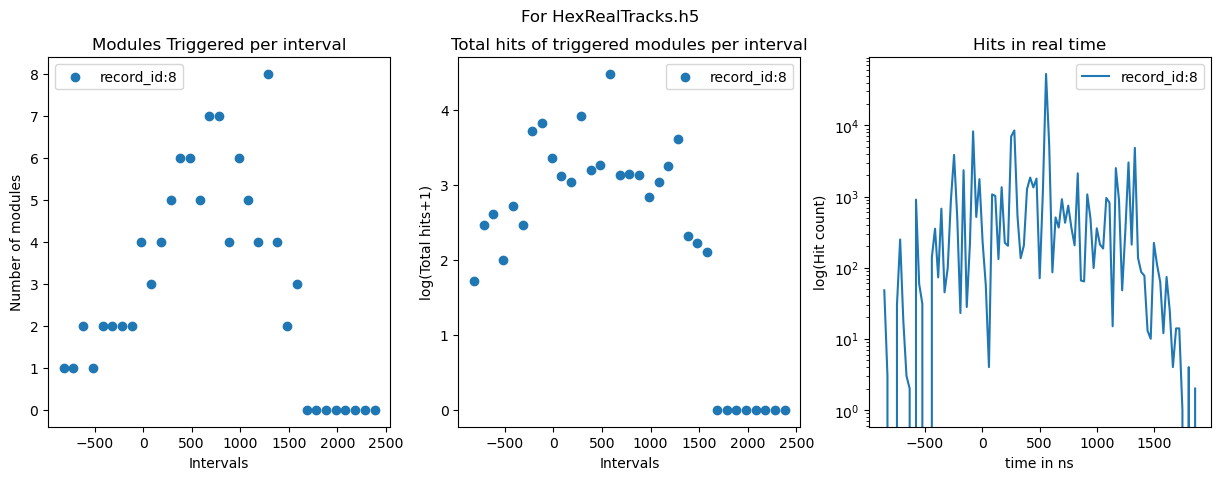

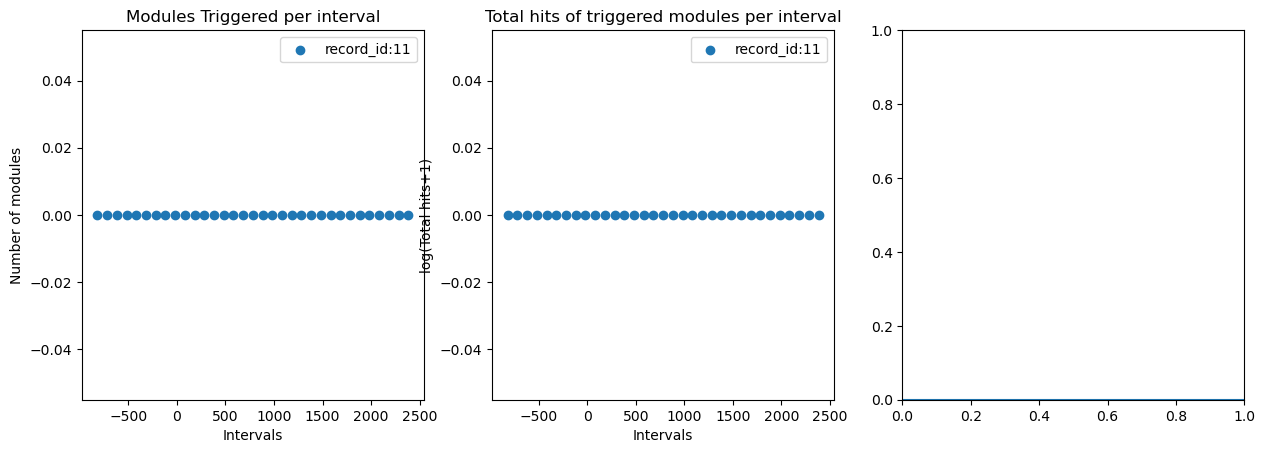

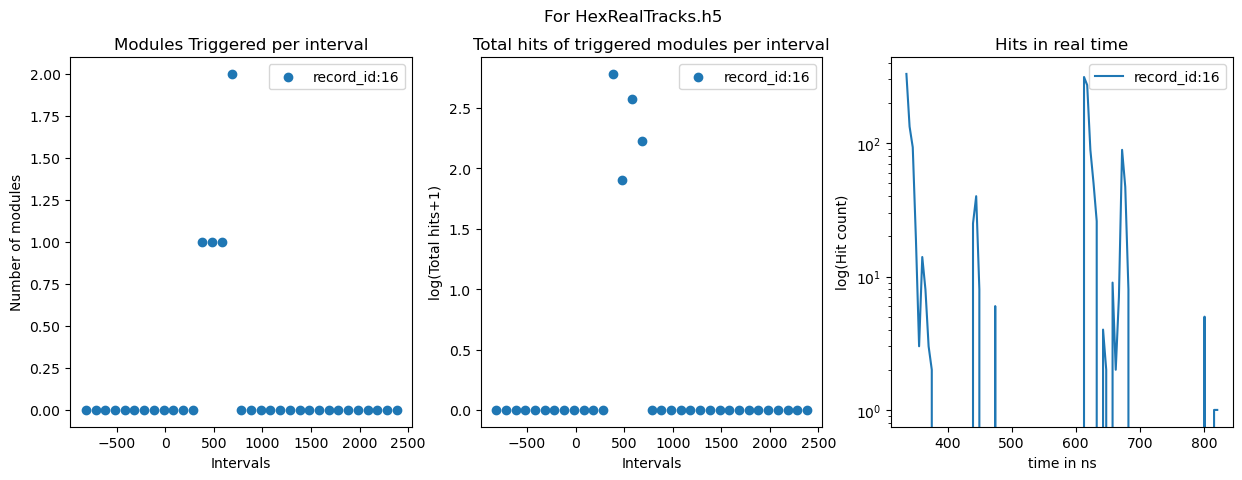

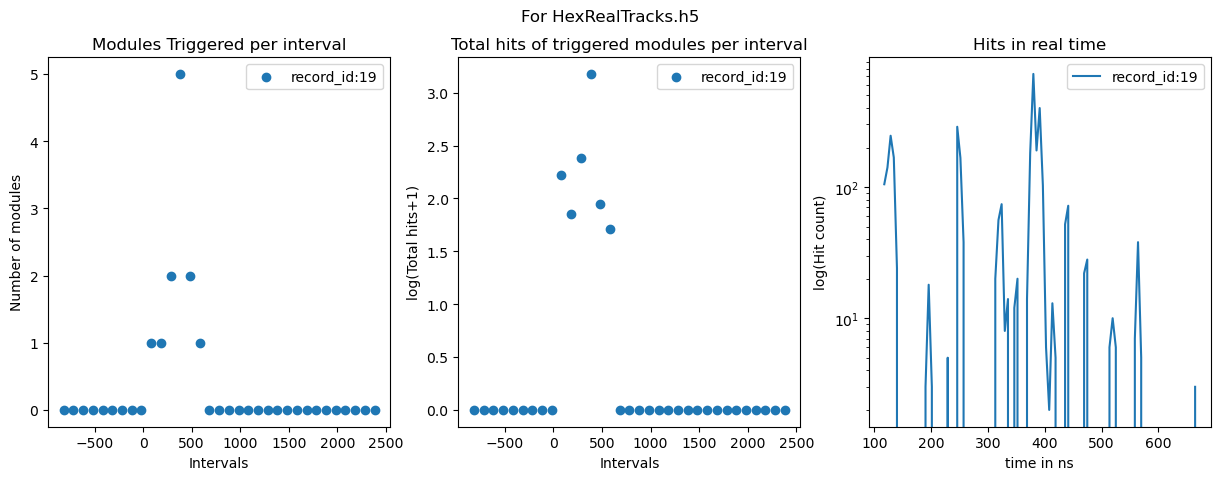

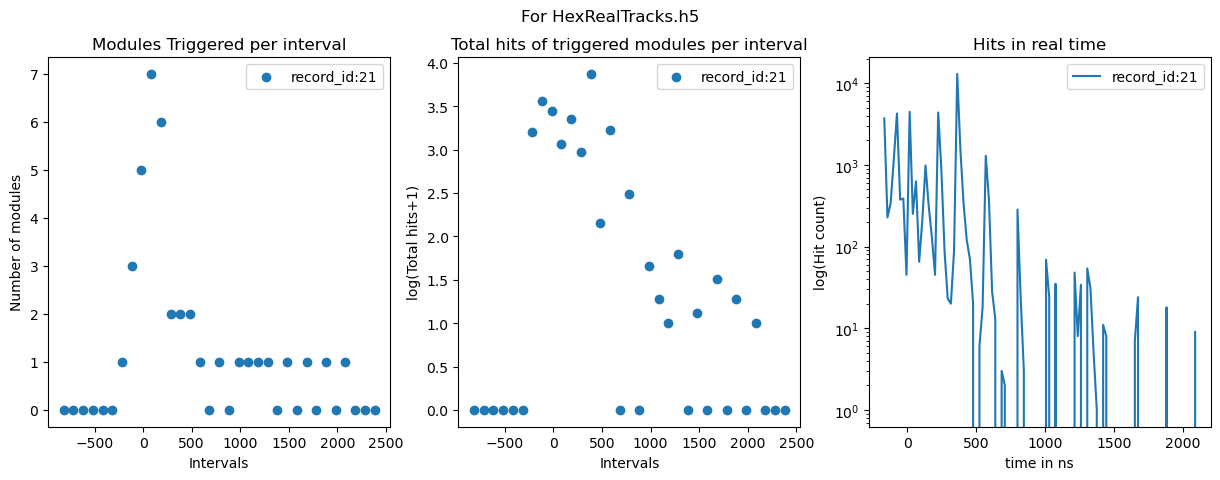

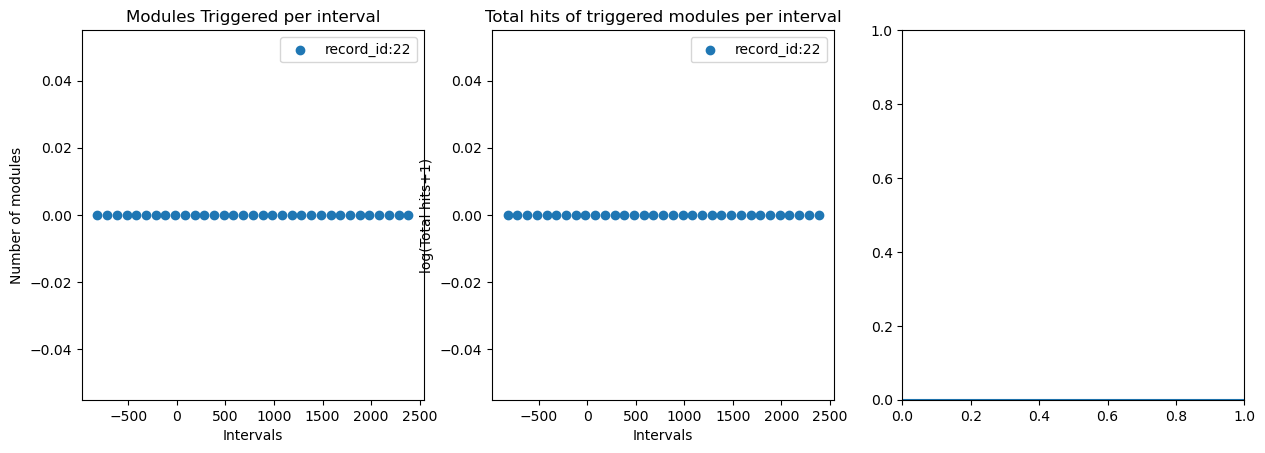

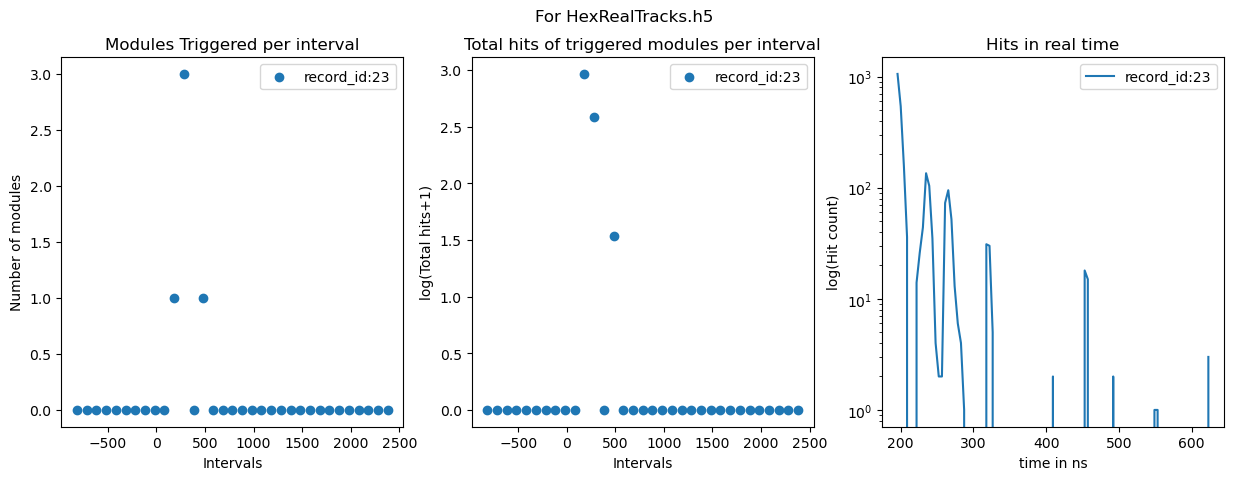

In [15]:

count=0
for (number_of_modules_triggered,hits_per_interval,hit_times,record) in \
zip(a,b,c,records):
    plt.figure().set_figwidth(15)
    plt.subplot(1, 3, 1)
    plt.scatter(intervals,number_of_modules_triggered,label='record_id:'+str(record))
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.scatter(intervals,np.log10(np.array(hits_per_interval)+1),label='record_id:'+str(record))
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('log(Total hits+1)')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    data=np.array(hit_times.sum())
    if data.size==1:
        plt.axhline(y=0,label='record_id:'+str(record))
        continue
    bins = np.linspace(min(data), max(data), num=100)  
    # Count occurrences in each bin
    counts, _ = np.histogram(data, bins)
    # Calculate bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot as a line plot
    plt.plot(bin_centers, counts,label='record_id:'+str(record))
    plt.xlabel('time in ns')
    plt.ylabel('log(Hit count)')
    plt.yscale('log')
    plt.title('Hits in real time')
    plt.legend()

    plt.suptitle('For '+path[5:])
    plt.show()

In [ ]:
intervals=process.intervals
count=0
for (number_of_modules_triggered,hits_per_interval,hit_times,record) in \
zip(a,b,c,records):
    plt.figure().set_figwidth(15)
    plt.subplot(1, 3, 1)
    plt.scatter(intervals,number_of_modules_triggered,label='record_id:'+str(record))
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.scatter(intervals,np.log10(np.array(hits_per_interval)+1),label='record_id:'+str(record))
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('log(Total hits+1)')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    data=np.array(hit_times.sum())
    if data.size==1:
        plt.axhline(y=0,label='record_id:'+str(record))
        continue
    bins = np.linspace(min(data), max(data), num=100)  
    # Count occurrences in each bin
    counts, _ = np.histogram(data, bins)
    # Calculate bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot as a line plot
    plt.plot(bin_centers, counts,label='record_id:'+str(record))
    plt.xlabel('time in ns')
    plt.ylabel('log(Hit count)')
    plt.yscale('log')
    plt.title('Hits in real time')
    plt.legend()

    plt.suptitle('For '+path[5:])
    plt.show()
    break

In [ ]:

count=0
for (number_of_modules_triggered,hits_per_interval,hit_times,record) in \
zip(NumberOfModsTriggeredPerRec,HitsPerIntervalPerRec,HitTiming,records):
    plt.figure().set_figwidth(15)
    plt.subplot(1, 3, 1)
    plt.scatter(intervals,number_of_modules_triggered,label='record_id:'+str(record))
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.scatter(intervals,np.log10(np.array(hits_per_interval)+1),label='record_id:'+str(record))
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('log(Total hits+1)')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    data=np.array(hit_times.sum())
    if data.size==1:
        plt.axhline(y=0,label='record_id:'+str(record))
        continue
    bins = np.linspace(min(data), max(data), num=100)  
    # Count occurrences in each bin
    counts, _ = np.histogram(data, bins)
    # Calculate bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot as a line plot
    plt.plot(bin_centers, counts,label='record_id:'+str(record))
    plt.xlabel('time in ns')
    plt.ylabel('log(Hit count)')
    plt.yscale('log')
    plt.title('Hits in real time')
    plt.legend()

    plt.suptitle('For '+path[5:])
    plt.show()
    break

In [ ]:
process=TriggerDatasetProcessor(path)

In [ ]:
a,b,c=process.run()

In [ ]:
from reorganised import TriggerDataset

In [ ]:
_=TriggerDataset(path)

In [ ]:
def consecutive_averages(numbers):
    # List to store the averages
    averages = []
    
    # Iterate over consecutive pairs and compute their average
    for i in range(len(numbers) - 1):
        avg = (numbers[i] + numbers[i + 1]) / 2
        averages.append(avg)
    
    return averages

# Example usage
#numbers = [1, 3, 5]
intervals = consecutive_averages(times)
#print(result)  # Output: [2.0, 4.0]
intervals

In [ ]:
intervals=(times[:-1]+times[1:])/2

In [ ]:
#plt.figure().set_figheight(14)
#plt.figure().set_figwidth(15)
count=0
for (number_of_modules_triggered,hits_per_interval,hit_times,record,
    number_of_mods_hit,ut_hits_per_interval,ut_hit_time) in \
zip(NumberOfModsTriggeredPerRec,HitsPerIntervalPerRec,HitTiming,records,
   NumberOfModsPerRecUT,HitsPerIntervalPerRecUT,HitTimingUT):
    
    #print(type(hit_times),type(ut_hit_time))
    #plt.figure().set_figwidth(15)
    plt.figure().set_size_inches(15,5)
    #plt.figure().set_figheight(10)
    plt.subplot(1, 3, 1)
    plt.scatter(intervals,number_of_mods_hit,label='total modules hit without trigger',color='b')
    plt.scatter(intervals,number_of_modules_triggered,label='modules triggred',color='r')
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.scatter(intervals,np.log10(ut_hits_per_interval+1),label='total hits in interval',color='b')
    plt.scatter(intervals,np.log10(hits_per_interval+1),label='triggered hits in interval',color='r')
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('Total hits (log scale)')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    data=np.array(hit_times.sum())
    data_ut=np.array(ut_hit_time.sum())
    bins = np.linspace(min(data_ut), max(data_ut), num=100)  
    # Count occurrences in each bin
    counts, _ = np.histogram(data_ut, bins)
    # Calculate bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot as a line plot
    plt.plot(bin_centers, counts,label='total hits in real time',color='b')
    

    
    plt.xlabel('time in ns')
    plt.ylabel('Hit count (log scale)')
    plt.yscale('log')
    plt.title('Hits in real time')

    if data.size==1:
        y=np.zeros(len(bin_centers))
        plt.plot(bin_centers,y,label='hline in real time',color='r')
        #plt.ylim(bottom=0)
    else:
        bins = np.linspace(min(data), max(data), num=100)  
        # Count occurrences in each bin
        counts, _ = np.histogram(data, bins)
        # Calculate bin centers for plotting
        bin_centers = (bins[:-1] + bins[1:]) / 2
        # Plot as a line plot
        plt.plot(bin_centers, counts,label='triggered hits in real time',color='r')
    
    plt.legend()
    plt.suptitle('For '+path[5:])
    plt.tight_layout()
    plt.show()

In [ ]:
#plt.figure().set_figheight(14)
#plt.figure().set_figwidth(15)
count=0
for (number_of_modules_triggered,hits_per_interval,hit_times,record,
    number_of_mods_hit,ut_hits_per_interval,ut_hit_time) in \
zip(NumberOfModsTriggeredPerRec,HitsPerIntervalPerRec,HitTiming,records,
   NumberOfModsPerRecUT,HitsPerIntervalPerRecUT,HitTimingUT):
    
    #print(type(hit_times),type(ut_hit_time))
    #plt.figure().set_figwidth(15)
    plt.figure().set_size_inches(15,5)
    #plt.figure().set_figheight(10)
    plt.subplot(1, 3, 1)
    plt.scatter(intervals,number_of_mods_hit,label='total modules hit without trigger',color='b')
    plt.scatter(intervals,number_of_modules_triggered,label='modules triggred',color='r')
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.scatter(intervals,np.log10(ut_hits_per_interval+1),label='total hits in interval',color='b')
    plt.scatter(intervals,np.log10(hits_per_interval+1),label='triggered hits in interval',color='r')
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('Total hits (log scale)')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    data=np.array(hit_times.sum())
    data_ut=np.array(ut_hit_time.sum())
    bins = np.linspace(min(data_ut), max(data_ut), num=100)  
    # Count occurrences in each bin
    counts, _ = np.histogram(data_ut, bins)
    # Calculate bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot as a line plot
    plt.plot(bin_centers, counts,label='total hits in real time',color='b')
    

    
    plt.xlabel('time in ns')
    plt.ylabel('Hit count (log scale)')
    plt.yscale('log')
    plt.title('Hits in real time')

    if data.size==1:
        plt.axhline(y=0,label='triggered hits in real time',color='r')
    else:
        bins = np.linspace(min(data), max(data), num=100)  
        # Count occurrences in each bin
        counts, _ = np.histogram(data, bins)
        # Calculate bin centers for plotting
        bin_centers = (bins[:-1] + bins[1:]) / 2
        # Plot as a line plot
        plt.plot(bin_centers, counts,label='triggered hits in real time',color='r')
    
    plt.legend()
    plt.suptitle('For '+path[5:])
    plt.tight_layout()
    plt.show()

In [ ]:
#plt.figure().set_figheight(14)
plt.figure().set_figwidth(15)
count=0
for (number_of_modules_triggered,hits_per_interval,hit_times,record,
    number_of_mods_hit,ut_hits_per_interval,ut_hit_time) in \
zip(NumberOfModsTriggeredPerRec,HitsPerIntervalPerRec,HitTiming,records,
   NumberOfModsPerRecUT,HitsPerIntervalPerRecUT,HitTimingUT):
    plt.figure().set_figwidth(15)
    plt.subplot(1, 3, 1)
    plt.scatter(intervals,number_of_modules_triggered,label='record_id:'+str(record))
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.scatter(intervals,np.log10(hits_per_interval+1),label='record_id:'+str(record))
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('log(Total hits+1)')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    data=np.array(hit_times.sum())
    if data.size==1:
        plt.axhline(y=0,label='record_id:'+str(record))
        continue
    bins = np.linspace(min(data), max(data), num=100)  
    # Count occurrences in each bin
    counts, _ = np.histogram(data, bins)
    # Calculate bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot as a line plot
    plt.plot(bin_centers, counts,label='record_id:'+str(record))
    plt.xlabel('time in ns')
    plt.ylabel('log(Hit count)')
    plt.yscale('log')
    plt.title('Hits in real time')
    plt.legend()

    plt.suptitle('For '+path[5:])
    plt.show()

In [ ]:
plt.axhline(y=0)
plt.ylim(-1,1)
plt.show()

In [ ]:
count=0
for (number_of_modules_triggered,hits_per_interval,hit_times,record) in \
zip(NumberOfModsTriggeredPerRec,HitsPerIntervalPerRec,HitTiming,records):
    plt.figure().set_figwidth(15)
    plt.suptitle('For '+path[5:])
    plt.subplot(1, 3, 1)
    plt.scatter(intervals,number_of_modules_triggered,label='record_id:'+str(record))
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.scatter(intervals,np.log10(hits_per_interval+1),label='record_id:'+str(record))
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('log(Total hits+1)')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    data=np.array(hit_times.sum())
    if data.size==1:
        plt.axhline(y=0,label='record_id:'+str(record))
        continue
    bins = np.linspace(min(data), max(data), num=100)  
    # Count occurrences in each bin
    counts, _ = np.histogram(data, bins)
    # Calculate bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot as a line plot
    plt.plot(bin_centers, counts,label='record_id:'+str(record))
    plt.xlabel('time in ns')
    plt.ylabel('log(Hit count)')
    plt.yscale('log')
    plt.title('Hits in real time')
    plt.legend()

    #plt.suptitle('For '+path[5:])
    plt.show()

In [ ]:
plt.figure().set_figheight(10)
for (number_of_modules_triggered,hits_per_interval,record) in \
zip(NumberOfModsTriggeredPerRec,HitsPerIntervalPerRec,records):
    plt.subplot(2, 1, 1)
    plt.scatter(intervals,number_of_modules_triggered,label='record_id:'+str(record))
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.scatter(intervals,np.log10(hits_per_interval+1),label='record_id:'+str(record))
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('log(Total hits+1)')
    plt.xlabel('Intervals')
    plt.legend()

plt.suptitle('For '+path[5:])
plt.show()

In [ ]:
plt.figure().set_figheight(10)
for (number_of_modules_triggered,hits_per_interval,record) in \
zip(NumberOfModsTriggeredPerRec,HitsPerIntervalPerRec,records):
    plt.subplot(2, 1, 1)
    plt.scatter(intervals,number_of_modules_triggered,label='record_id:'+str(record))
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.scatter(intervals,np.log10(hits_per_interval+1),label='record_id:'+str(record))
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('log(Total hits+1)')
    plt.xlabel('Intervals')
    plt.legend()

plt.suptitle('For '+path[5:])
plt.show()

In [ ]:
plt.figure().set_figheight(10)
for (number_of_modules_triggered,hits_per_interval,record) in \
zip(NumberOfModsTriggeredPerRec,HitsPerIntervalPerRec,records):
    plt.subplot(2, 1, 1)
    plt.scatter(intervals,number_of_modules_triggered,label='record_id:'+str(record))
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.scatter(intervals,np.log10(hits_per_interval+1),label='record_id:'+str(record))
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('log(Total hits+1)')
    plt.xlabel('Intervals')
    plt.legend()

plt.suptitle('For '+path[5:])
plt.show()

In [ ]:
plt.figure().set_figheight(10)
for (number_of_modules_triggered,hits_per_interval,record) in \
zip(NumberOfModsTriggeredPerRec,HitsPerIntervalPerRec,records):
    plt.subplot(2, 1, 1)
    plt.scatter(intervals,number_of_modules_triggered,label='record_id:'+str(record))
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.scatter(intervals,np.log10(hits_per_interval+1),label='record_id:'+str(record))
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('log(Total hits+1)')
    plt.xlabel('Intervals')
    plt.legend()

plt.suptitle('For '+path[5:])
plt.show()

In [ ]:
plt.figure().set_figheight(10)
for (number_of_modules_triggered,hits_per_interval,record) in \
zip(NumberOfModsTriggeredPerRec,HitsPerIntervalPerRec,records):
    plt.subplot(2, 1, 1)
    plt.scatter(intervals,number_of_modules_triggered,label='record_id:'+str(record))
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.scatter(intervals,np.log10(hits_per_interval+1),label='record_id:'+str(record))
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('log(Total hits+1)')
    plt.xlabel('Intervals')
    plt.legend()

plt.suptitle('For '+path[5:])
plt.show()

In [ ]:
plt.figure().set_figheight(10)
for (number_of_modules_triggered,hits_per_interval,record) in \
zip(NumberOfModsTriggeredPerRec,HitsPerIntervalPerRec,records):
    plt.subplot(2, 1, 1)
    plt.scatter(intervals,number_of_modules_triggered,label='record_id:'+str(record))
    plt.title('Modules Triggered per interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.scatter(intervals,np.log10(hits_per_interval+1),label='record_id:'+str(record))
    plt.title('Total hits of triggered modules per interval')
    plt.ylabel('log(Total hits+1)')
    plt.xlabel('Intervals')
    plt.legend()

plt.suptitle('For Hex Cascades')
plt.show()

In [ ]:
x=time.time()
t_max=max(hits.df['time'])
t_min=min(hits.df['time'])
time_intervals=np.arange(t_min,t_max,100)
time_intervals
ploting_data=[]
check=[]
for record_id in records.df['record_id']:#gives record id so i can get set triggers per record
    
    #defining variables
    current_module=None
    pmt_count=0
    number_of_hits=[]
    mean_time_interval=[]
    #getting hits for one record
    hit=hits.get_by_record_ids(record_id)
    #this bit makes it so that you get the number of hits per pmt
    groupedhit=hit.df.groupby(['string_id','module_id','pmt_id']).agg(list)[['time']]
    #source=sources.get_by_record_ids(record_id)
    for t1, t2 in zip(time_intervals, time_intervals[1:]): #t1-t2=100ns
        total_hit_count_per_time_interval=0 #total hits in a given time interval
        hits_per_module=0
        modules_triggered_per_time_interval=0
        for i in groupedhit.iterrows():
            a=i[1]
            #checks if in a given interval the given pmt has a hit
            #and returns the number of hits in the interval
            count=hits_in_interval(a['time'],t1,t2)
            if count>0:
                hits_per_module+=count
                #if there is a positive count it enters the if statement
                #it checks if the module the pmt belongs to got a hit before
                #if yes incriment the pmt_count
                if current_module==i[0][:2]:
                    pmt_count+=1
                    
                else:
                #else that mean a new module has been accessed 
                #so we save the total hits for the previous module
                #and then we note down the next module and then continue the loop
                    if trigger_check(pmt_count):
                        modules_triggered_per_time_interval+=1
                        total_hit_count_per_time_interval+=hits_per_module
                        
                    hits_per_module=0    
                    current_module=i[0][:2]
                    pmt_count=1
                    
        ploting_data.append([total_hit_count_per_time_interval,
                             modules_triggered_per_time_interval,
                             (t1+t2)/2])
    #break
print(time.time()-x)

In [ ]:
array=np.array(ploting_data,dtype=int)
time_intervals.shape
array.shape

In [ ]:
groupedhit.shape

In [ ]:
hits.df[['time','record_id']]

In [ ]:
chunk=array.shape[0]//time_intervals.shape[0]
t=time_intervals.shape[0]
for i in range(10,20):
    plt.scatter(array[i*t:(i+1)*t,2],(array[i*t:(i+1)*t,0]),label=str(i+1)+' th record')
plt.legend()
plt.xlabel('mean time interval')
plt.ylabel('hits')
plt.show()

In [ ]:
for i in range(15):
    plt.scatter(array[i*9:(i+1)*9,1],array[i*9:(i+1)*9,0],label=str(i+1)+' th record')
plt.legend()
plt.xlabel('mean time interval')
plt.ylabel('hits')
plt.show()

In [ ]:
for i in range(15):
    plt.scatter(array[i*9:(i+1)*9,1],array[i*9:(i+1)*9,0],label=str(i+1)+' th record')
plt.legend()
plt.xlabel('mean time interval')
plt.ylabel('hits')
plt.show()

In [ ]:
for i in range(15):
    plt.scatter(array[i*9:(i+1)*9,1],array[i*9:(i+1)*9,0],label=str(i+1)+' th record')
plt.legend()
plt.xlabel('mean time interval')
plt.ylabel('hits')
plt.show()

In [ ]:
len(detector.df['pmt_id'].drop_duplicates())

In [ ]:
recordids=np.sort(records.df['record_id'])

In [ ]:
from ananke.visualisation.detector import get_detector_scatter3ds

In [ ]:
for ID in recordids: 
    #print(type(ID))
    fig=get_detector_scatter3ds(
            detector,
            include_modules=True,
            include_pmts=True,
            hits=hits.get_by_record_ids(int(ID)),
            sources=sources.get_by_record_ids(int(ID))
        )
    fig.show()